# Anomaly Detection using CNN Autoencoder

### Loading Data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qo "/content/drive/MyDrive/Colab Notebooks/Corso_ML/fruits_anomaly_detection.zip"

### Import

In [ ]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from PIL import Image, ImageChops
import random

### Create generators for training, validation and testing

- Read data from folders using ImageDataGenerator
- Generate data from the images in a folder, allows use of datasets that do not fit in main memory all at once
- Image resizing is done by the generator so a folder with any sized-images can be used

The named directory must contain one or more subfolders, path should look like `apples_train/apple_class1/img1.jpg`


- Generate batches of tensor image data with real-time data augmentation.
- A DirectoryIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.

---
`flow_from_directory(directory)`

**Description**: Takes the path to a directory, and generates batches of augmented/normalized data (Yields batches indefinitely, in an infinite loop.)

In [ ]:
batch_size = 85
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last') # 96x96x3
train_generator = train_datagen.flow_from_directory(
    '/content/fruits_anomaly_detection/apples_train',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input'   # the output is the input itself
    )

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
validation_generator = test_datagen.flow_from_directory(
    '/content/fruits_anomaly_detection/apples_test/',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = test_datagen.flow_from_directory(
    '/content/fruits_anomaly_detection/eggplant',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='input'
    )
#(X, y)

Found 6416 images belonging to 13 classes.
Found 2138 images belonging to 13 classes.
Found 468 images belonging to 3 classes.


## **Autoencoder Architecture**

As we have seen in the case of MLP Autoencoder, we build a structure composed by an **Encoder**, that able to reduce the dimensions of our data (extract latent fetaures), and a **Decoder**, that is able to restore the original dimensions.

The output has to have the same structure of the input, the objective is to learn a model able to reconstruct well (producing small reconstruction error) data coming from the same distribution of the training data.

Different data (for example anomalies) should produce higher reconstruction error.

In order to inncrease the data size in the Decoder part we can use the class
**`UpSampling2D`**  https://keras.io/api/layers/reshaping_layers/up_sampling2d/


In [ ]:
# Define the convolutional autoencoder model

# input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the original image
model = Sequential()
#-------------------------

#encoder
model.add(Conv2D(16, (3, 3), padding='same',activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(4,4), padding='same')) # using pool_size (4,4) makes the layer 4x smaller in height and width

model.add(Conv2D(8,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(4,4), padding='same'))

model.add(Conv2D(3,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#decoder
model.add(Conv2D(3, (3,3 ), activation = "relu", padding = "same"))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(8, (3, 3), activation = "relu", padding = "same"))
model.add(UpSampling2D((4, 4)))

model.add(Conv2D(16, (3, 3), activation ="relu", padding = "same"))
model.add(UpSampling2D((4,4))) #96x96x 16-> 3 = rgb

model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same')) #96x96x3
#-------------------------

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# MAE can compute the difference between the image in input and the one produced in output (the reconstructed one)

### **Training**

Define `steps_per_epoch`:
- Is the Total number of steps (batches of samples) to yield from generator
- before declaring one epoch finished and starting the next epoch.
- It should typically be equal to `ceil(num_samples / batch_size)`.

EarlyStopping callback in combination with ModelCheckpoint https://keras.io/api/callbacks/


In [ ]:
# Training the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = 'image_anomaly_ae.h5'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss',
                                            save_best_only=True, mode='min', verbose = 1)
# Saves the best version of the model to disk (as measured on the validation data set)

# model.fit(X_train, y_train, etc..)
model.fit(train_generator, #-> (X,y) ~~ (X_train, y_train) -> generator output (X, X) , class_mode = input
        steps_per_epoch = train_generator.samples // train_generator.batch_size,
        epochs=50,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples // validation_generator.batch_size,
        shuffle = True,
        callbacks=[es, save_best])

Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.0880
Epoch 1: val_loss improved from inf to 0.05299, saving model to image_anomaly_ae.h5
75/75 [==============================] - 15s 94ms/step - loss: 0.0880 - val_loss: 0.0530
Epoch 2/50
 1/75 [..............................] - ETA: 8s - loss: 0.0528

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - ETA: 0s - loss: 0.0414
Epoch 2: val_loss improved from 0.05299 to 0.03573, saving model to image_anomaly_ae.h5
75/75 [==============================] - 8s 102ms/step - loss: 0.0414 - val_loss: 0.0357
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.0333
Epoch 3: val_loss improved from 0.03573 to 0.03258, saving model to image_anomaly_ae.h5
75/75 [==============================] - 6s 86ms/step - loss: 0.0333 - val_loss: 0.0326
Epoch 4/50
75/75 [==============================] - ETA: 0s - loss: 0.0310
Epoch 4: val_loss improved from 0.03258 to 0.03113, saving model to image_anomaly_ae.h5
75/75 [==============================] - 7s 100ms/step - loss: 0.0310 - val_loss: 0.0311
Epoch 5/50
75/75 [==============================] - ETA: 0s - loss: 0.0296
Epoch 5: val_loss improved from 0.03113 to 0.02989, saving model to image_anomaly_ae.h5
75/75 [==============================] - 7s 89ms/step - loss: 0.0296 - val_loss: 0.0299
Epoch

Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter

In [ ]:
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model_filepath = 'image_anomaly_ae.h5'
model = keras.models.load_model(model_filepath)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 3)           219       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 3)           0

Test the model by viewing a sample of original and reconstructed images.

A `DirectoryIterator` yielding tuples of `(x, y)` where `x` is a numpy array containing a batch of images with shape `(batch_size, *target_size, channels)` and `y` is a numpy array of corresponding labels.

### Testing

In [ ]:
# Get extract some batches with the generator
data_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
    data = train_generator.next()
    data_list.append(data[0]) # just get the input batches
    ## each entry is a batch of shape (n_records,size,size,channels)=(85,96,96,3)
    batch_index = batch_index + 1

print(len(data_list))
print(data_list[0].shape)


76
(85, 96, 96, 3)


3/3 [==============================] - 0s 11ms/step


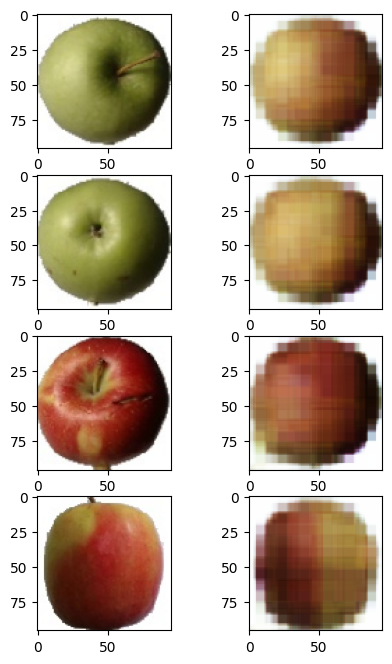

In [ ]:
# Plot some original samples vs reconstructed samples

predicted = model.predict(data_list[0])   #compute prediction for the first batch

no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(data_list[0][i])
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [ ]:
# Get images from eggplant (which we consider to be anomalous data)

# Test the model by viewing a sample of original and reconstructed images
eggplant_data_list = []
batch_index = 0
while batch_index <= anomaly_generator.batch_index:
    print("batch_index: ", batch_index, "anomaly_generator batch_index: ", anomaly_generator.batch_index)
    data = anomaly_generator.next()
    eggplant_data_list.append(data[0])
    batch_index = batch_index + 1

print(len(eggplant_data_list))
print(eggplant_data_list[0].shape)


batch_index:  0 anomaly_generator batch_index:  0
batch_index:  1 anomaly_generator batch_index:  1
batch_index:  2 anomaly_generator batch_index:  2
batch_index:  3 anomaly_generator batch_index:  3
batch_index:  4 anomaly_generator batch_index:  4
batch_index:  5 anomaly_generator batch_index:  5
6
(85, 96, 96, 3)


3/3 [==============================] - 0s 4ms/step


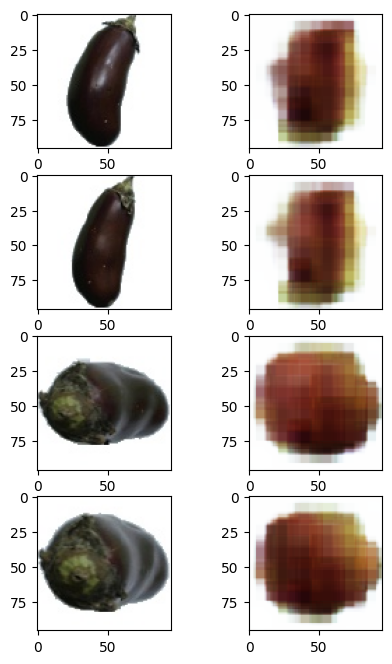

In [ ]:
# Plot some original eggplants vs reconstructed eggplants
predicted = model.predict(eggplant_data_list[0]) #get prediction/reconstructions for the first batch of eggplants
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(eggplant_data_list[0][i])
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()


In [ ]:
# Get images from apple test

# Test the model by viewing a sample of original and reconstructed images
apple_test_list = []
batch_index = 0
while batch_index <= validation_generator.batch_index:
    #print("batch_index: ", batch_index, "validation_generator batch_index: ", validation_generator.batch_index)
    data = validation_generator.next()
    apple_test_list.append(data[0]) #just get the input batches
    batch_index = batch_index + 1

print(len(apple_test_list))
print(apple_test_list[0].shape)


26
(85, 96, 96, 3)


3/3 [==============================] - 0s 5ms/step


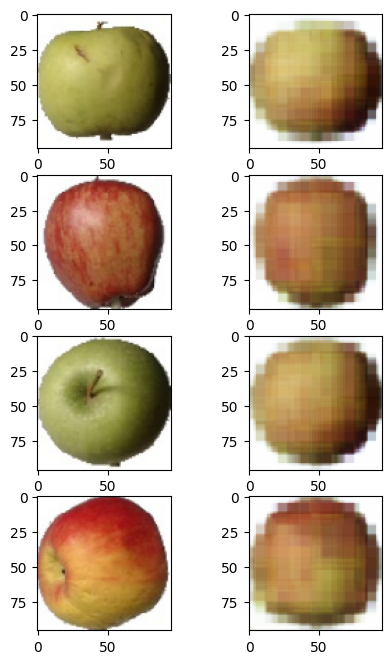

In [ ]:
# Apple test samples: original vs reconstructed
predicted = model.predict(apple_test_list[0])
no_of_samples = 4
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 8))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(apple_test_list[0][i])
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()


### **Evaluation**

In [ ]:
# We want the difference the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate(validation_generator)},error on anomaly set:{model.evaluate(anomaly_generator)}") #MSE

6/6 [==============================] - 1s 89ms/step - loss: 0.0515
Error on validation set:0.017897410318255424,error on anomaly set:0.05148753523826599


#### **Analysis of the reconstruction errors**

1/1 [==============================] - 0s 19ms/step


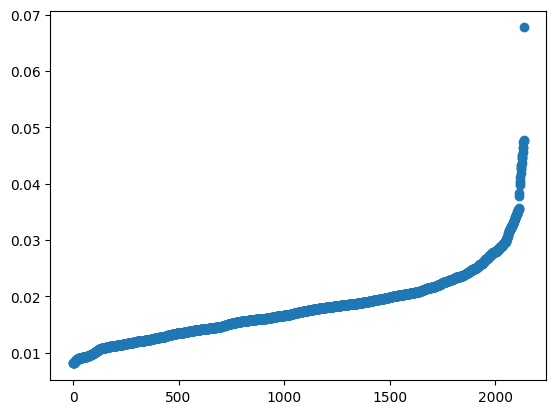

In [ ]:
error_list = []
for idx in range(len(apple_test_list)): #iterate over batches

  r = model.predict(apple_test_list[idx])   #get prediction of batch with index idx

  #MSE
  r_error  = [np.square(apple_test_list[idx][i] - r[i]).mean() for i in range(len(apple_test_list[idx]))]
  # MSE Mean squared (reconstruction) error between the original image and the reconstructed one
  error_list.append(r_error) #error_list is a list of list: so I will flatten everything out.


error_flat_list = [item for sublist in error_list for item in sublist]

plt.scatter(x = range(len(error_flat_list)), y = sorted(error_flat_list))

2/2 [==============================] - 0s 316ms/step


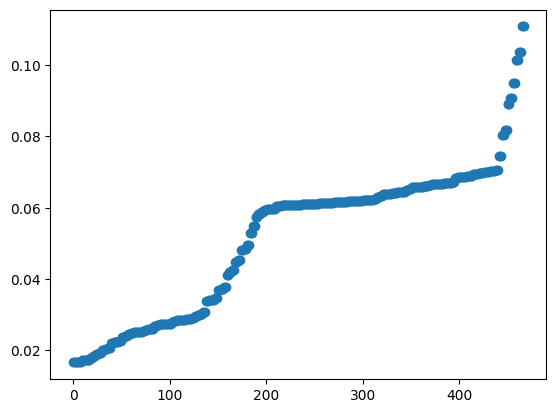

In [ ]:
# Get the reconstructions errors for eggplants
error_list_eggplant = []
for idx in range(len(eggplant_data_list)):
  r = model.predict(eggplant_data_list[idx])

  r_error  = [np.square(eggplant_data_list[idx][i] - r[i]).mean() for i in range(len(eggplant_data_list[idx]))]

  error_list_eggplant.append(r_error)

error_flat_list_eggplant = [item for sublist in error_list_eggplant for item in sublist]
# total_error = sum(error_flat_list_eggplant)

plt.scatter(x = range(len(error_flat_list_eggplant)), y = sorted(error_flat_list_eggplant))

#### **Count anomalies on apple test given a threshold**

In [ ]:
# Anomaly detection on apple_test samples
count_anomaly = 0
threshold = 0.04

count_anomaly = sum(i > threshold for i in error_flat_list) #apples has MSE - label 0
# in this case count_anomaly represents the FP (apples that are classified as anomalies)
count_normal = sum(i <= threshold for i in error_flat_list)
print("apple test anomaly {} over a total of {} apple test".format(count_anomaly, len(error_flat_list)))
print(count_anomaly/(len(error_flat_list)))

apple test anomaly 20 over a total of 2138 apple test
0.009354536950420954


In [ ]:
# Count anomalies on eggplants
#anomaly detection in the eggplant samples
count_anomaly = 0
threshold = 0.04

count_anomaly = sum(i > threshold for i in error_flat_list_eggplant)#eggplant has MSE -label 1
count_normal = sum(i <= threshold for i in error_flat_list_eggplant)
# in this case count_normal represents the FN (eggplants that are classified as normal)


print("eggplant anomaly {} over a total of {} eggplant test".format(count_anomaly, len(error_flat_list_eggplant)))
print(count_anomaly/(len(error_flat_list_eggplant)))

eggplant anomaly 438 over a total of 468 eggplant test
0.9358974358974359


#### **ROC Curve**

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import pandas as pd

# Assign labels
# Create labels for normal and anomaly samples
apple_test_labels =  np.zeros(len(error_flat_list))    #normal label = 0
eggplant_test_labels = np.ones(len(error_flat_list_eggplant)) #anomaly label = 1

# Put all the labels together
all_labels = np.concatenate((apple_test_labels, eggplant_test_labels))

# Put together the reconstruction errors and Target_scores
all_errors  = error_flat_list + error_flat_list_eggplant

# Create a dataframe to store all the above information, to have everything together
# This way we can compute some statistics easily

error_df = pd.DataFrame({'reconstruction_error': all_errors,
                         "true_class": all_labels})
error_df.describe()
print(error_df.head())
print(error_df.tail())


   reconstruction_error  true_class
0              0.013954         0.0
1              0.014227         0.0
2              0.015406         0.0
3              0.018465         0.0
4              0.027333         0.0
      reconstruction_error  true_class
2601              0.070487         1.0
2602              0.068529         1.0
2603              0.061495         1.0
2604              0.060708         1.0
2605              0.065990         1.0


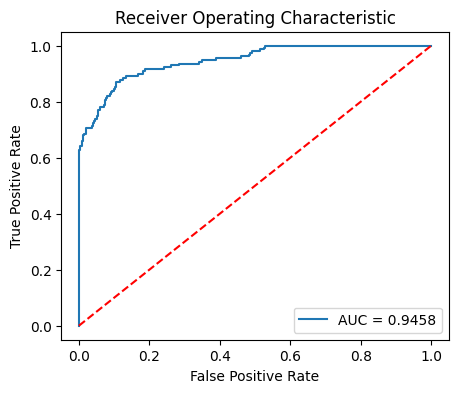

In [ ]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
# fpr, tpr, thresholds = roc_curve(all_labels, all_errors)

# AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show();

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Threshold ottimale:", optimal_threshold)

Threshold ottimale: 0.02499602


## **OneClass SVM for anomaly detection**

 SVMs use hyperplanes in multi-dimensional space to separate one class of observations from another. Naturally, SVM is used in solving multi-class classification problems.

However, SVM is also increasingly being used in one class problem, where all data belong to a single class. In this case, the algorithm is trained to learn what is “normal”, so that when a new data is shown the algorithm can identify whether it should belong to the group or not. If not, the new data is labeled as out of ordinary or anomaly.

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_blobs
from numpy import quantile, where, random
import matplotlib.pyplot as plt

**Preparing the data**

We create a toy dataset for this tutorial by using the make_blob() function. We can check the dataset by visualizing it in a plot.



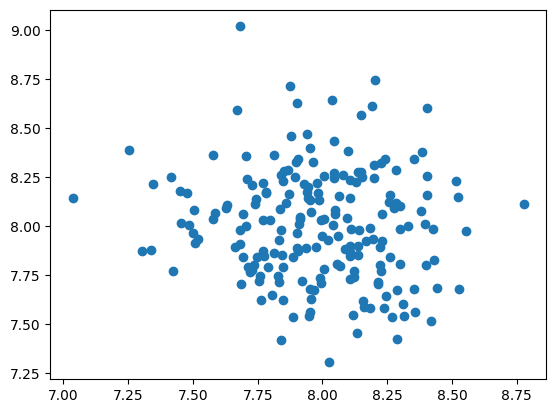

In [ ]:
random.seed(13)
x, _ = make_blobs(n_samples=200, centers=1, cluster_std=.3, center_box=(8, 8))

plt.scatter(x[:,0], x[:,1])
plt.show()

**Defining the model and prediction**

OneClassSVM(gamma=0.001, nu=0.03)


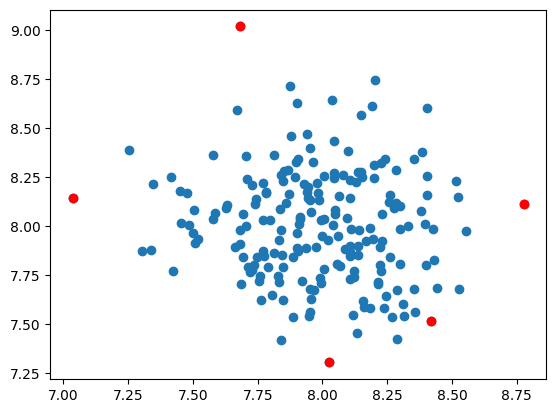

In [ ]:
#TO DO: create the model
#svm = OneClassSVM()
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.03)
print(svm)

#TO DO fit the model & predict
svm.fit(x)
pred = svm.predict(x) #1 for inliers; -1 for outliers
# print(pred)

#TO DO: extract the negative outputs as outliers
anom_index = where(pred == -1)
values = x[anom_index]

#visualize the results in a plot, highlighting with red the anomalies/outliers
plt.scatter(x[:,0], x[:,1])
plt.scatter(values[:,0], values[:,1], color='r')
plt.show()

OneClassSVM(gamma=0.001, nu=0.02)
[3.99517818 3.99517513 3.99690317 3.99660933 3.99573462 3.99567333
 3.99668516 3.99651558 3.99420256 3.99532573 3.99616153 3.99681575
 3.99652906 3.99661741 3.99622892 3.99690687 3.99684587 3.99625341
 3.9959001  3.99658804 3.99679424 3.99439546 3.99615081 3.99687574
 3.99654659 3.9962101  3.99548436 3.99626823 3.99618992 3.99651924
 3.99564684 3.99658044 3.99694729 3.99692815 3.99674385 3.99634505
 3.99601731 3.99600645 3.99686671 3.99692047 3.99692848 3.99404225
 3.99628042 3.99500329 3.99690404 3.99643243 3.99690443 3.99687902
 3.99419167 3.9968199  3.99687175 3.99682293 3.99556544 3.99411355
 3.99623042 3.99594508 3.99674105 3.99585003 3.99667034 3.99650245
 3.99637754 3.99634896 3.99616399 3.99683238 3.99576806 3.99679253
 3.99691516 3.99532976 3.99487888 3.99661618 3.99591369 3.99651199
 3.99667065 3.99631226 3.99692994 3.99632428 3.99622426 3.99683373
 3.99663784 3.99688503 3.99630692 3.99615849 3.99638525 3.99541707
 3.99528821 3.99530539 3.996

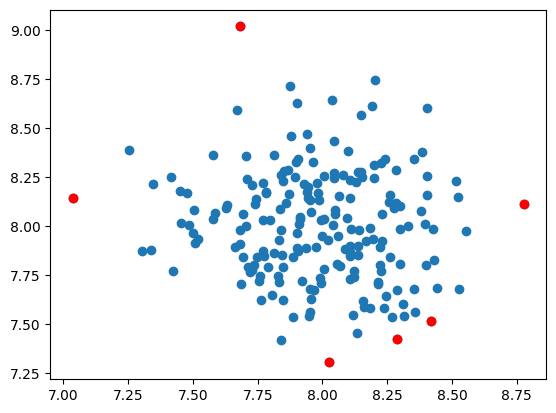

In [ ]:
# anomaly detection with scores
# We can find anomalies by using their scores.
# In this method, we'll define the model, fit it on the x data by using the fit_predict() method.
# We'll calculate the outliers according to the score value of each element.

svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.02)
print(svm)

#TO DO : fit the model and extract sample scores
pred = svm.fit_predict(x)
scores = svm.score_samples(x)

print(scores)

#TO DO: get the threshold values from the scores using the quantile function
#for example, get the lowest 3-percent of score values as the anomalies
thresh = quantile(scores, 0.03)
print(thresh)

#TO DO: extract the anomalies by comparing the threshold value and identify the values of elements
index = where(scores<=thresh)
values = x[index]

#visualize the data, anomalies are colored in red
plt.scatter(x[:,0], x[:,1])
plt.scatter(values[:,0], values[:,1], color='r')
plt.show()